# Description of the use of pixel-level classification of multimodal remotely sensed data

This document provides a guide for utilizing open-source code to perform pixel-level classification on multimodal remote sensing data. The accompanying notebook offers a basic demonstration of the project, showcasing the experimental results from the paper **"Hierarchical Gated Network for Multimodal Remote Sensing Imagery Classification with Limited Data"** and illustrating the plotting methods used in Fig2 and Fig3. Built on the PyTorch framework, the code facilitates the reading of HSI (Hyperspectral Imaging), SAR (Synthetic Aperture Radar), and DSM (Digital Surface Modeling) multimodal data, dataset construction, classification, and result visualization.

### 1. Model loading

In [1]:
import sys
import torch

sys.path.append("..")
from mm_model import HGN

model = HGN([180, 4, 1], n_classes=7)
model_dict = torch.load("../checkpoints/Augsburg-HGN-100.pt", weights_only=True)
model.load_state_dict(model_dict)

<All keys matched successfully>

### 2. Dataset Configuration

In [2]:
from torch.utils.data import DataLoader
from mmrs_utils import RSMultiData, RSMultiDataset

multi_data = RSMultiData(
    tr="../data/Augsburg/TRLabel.mat",
    ts="../data/Augsburg/TSLabel.mat",
    HSI="../data/Augsburg/HSI.mat",
    SAR="../data/Augsburg/SAR.mat",
    DSM="../data/Augsburg/DSM.mat",
)
dataset = RSMultiDataset(multi_data, is_train=False, patch_size=7, slice_method="ignore", ignore=[0])
test_loader = DataLoader(dataset, batch_size=64, shuffle=False)

### 3. Evaluation function

In [3]:
from mmrs_utils import AverageMeter


def evalution(model: torch.nn.Module, test_loader: DataLoader, device: str, manager):
    model.eval()
    model = model.to(device)
    acc_meter = AverageMeter()
    ticks = manager.counter(total=len(test_loader), desc="Evalution testset", unit="pixel", color="red", leave=False)
    with torch.no_grad():
        for data, gt, _ in test_loader:
            data, gt = [d.to(device) for d in data], gt.to(device)
            output = model(data)
            try:
                acc_meter.update(torch.argmax(output, dim=1), gt)
            except TypeError:
                acc_meter.update(torch.argmax(output[0], dim=1), gt)
            ticks.update()
    ticks.close()
    return acc_meter.avg, acc_meter.cale_kappa()

### 4. Evaluation and visualization of results

100% dataset test OA = 92.01 %  kappa = 0.8833


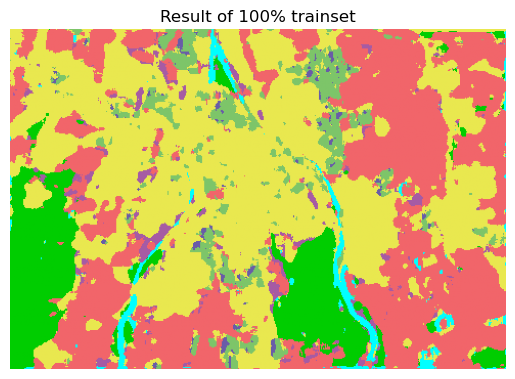

In [4]:
import matplotlib.pyplot as plt
import enlighten
from mmrs_utils import draw_result

# You can customize cmap
Augsburg_cmap = {
    0: [0, 0, 0],
    1: [0, 205, 0],
    2: [233, 232, 79],
    3: [125, 197, 105],
    4: [241, 101, 106],
    5: [166, 91, 164],
    6: [105, 92, 168],
    7: [0, 255, 255],
}

message = "Evaluating the dataset Augsburg on the HGN model and the training sampling rate is 100%"
manager = enlighten.get_manager()
status_bar = manager.status_bar("", color="white_on_green", justify=enlighten.Justify.CENTER)
status_bar.update(message)
testacc, test_kappa = evalution(model, test_loader, "cuda:0", manager)
print(f"100% dataset test OA = {testacc:.2f} %  kappa = {test_kappa:.4f}")

rgb_image = draw_result(
    multi_data,
    manager=manager,
    model=model,
    device="cuda:0",
    ignore=[],
    batch_size=1024,
    cmap=Augsburg_cmap,
    patch_size=7,
)
plt.imshow(rgb_image)
plt.axis("off")
plt.title("Result of 100% trainset")
plt.show()

### You can also choose to ignore certain categories (0 for background categories)

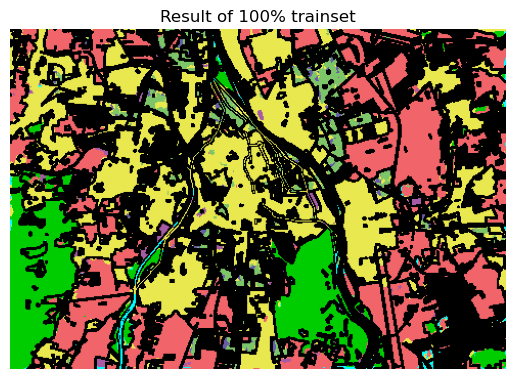

In [5]:
rgb_image = draw_result(
    multi_data,
    manager=manager,
    model=model,
    device="cuda:0",
    ignore=[0],
    batch_size=1024,
    cmap=Augsburg_cmap,
    patch_size=7,
)
plt.imshow(rgb_image)
plt.axis("off")
plt.title("Result of 100% trainset")
plt.show()

### Ignore the background category and the first category

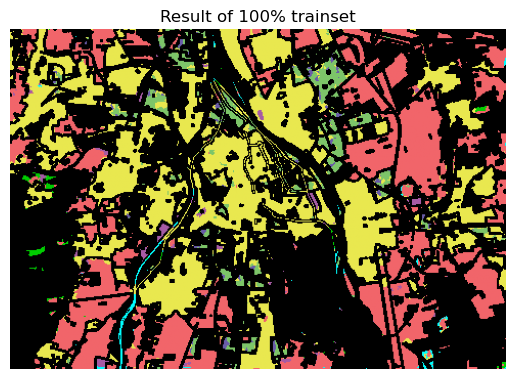

In [6]:
rgb_image = draw_result(
    multi_data,
    manager=manager,
    model=model,
    device="cuda:0",
    ignore=[0, 1],
    batch_size=1024,
    cmap=Augsburg_cmap,
    patch_size=7,
)
plt.imshow(rgb_image)
plt.axis("off")
plt.title("Result of 100% trainset")
plt.show()

### 5. Visualization of ground truth

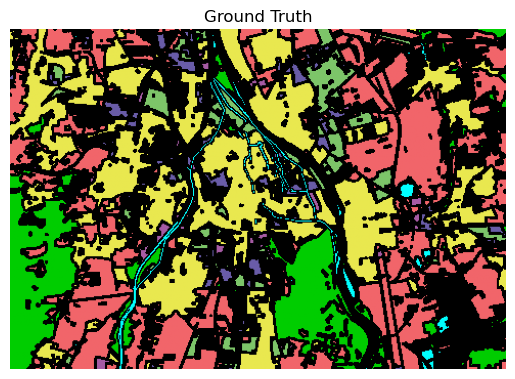

In [9]:
rgb_image = draw_result(multi_data, ignore=[0], batch_size=1024, cmap=Augsburg_cmap)
plt.imshow(rgb_image)
plt.axis("off")
plt.title("Ground Truth")
plt.show()

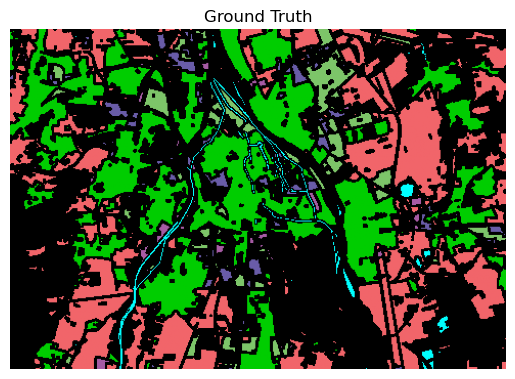

In [8]:
rgb_image = draw_result(multi_data, ignore=[0, 1], batch_size=1024, cmap=Augsburg_cmap)
plt.imshow(rgb_image)
plt.axis("off")
plt.title("Ground Truth")
plt.show()